<a href="https://colab.research.google.com/github/dimsparagis0210/DFU-using-Deep-Learning/blob/main/SSD_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Faster-RCNN Model Development

#### The goal of this BSc thesis is to develop a Deep Learning model for Object Detection. Specifically, the object of the model will be to detect ulcers in Diabetic Foots (DFU)

## Getting Dataset from Google drive

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

# Define dataset path (adjust if needed)
dataset = '/content/drive/MyDrive/DFU_Data_Coco'
trainset = dataset + '/images/train'
testset = dataset + '/images/test'
validset = dataset + '/images/valid'

# List categories (folders)
os.listdir('/content/drive/MyDrive')

['Colab Notebooks',
 'ML',
 'Machine Learning A-Z (Model Selection)',
 'Deep Learning',
 'ML_task',
 'Screencastify',
 'DFU',
 'IoT, Big Data, AI Smart Farms.gdoc',
 'Conceptual Analysis of the Study on Environmentally Sustainable Smart Cities.gdoc',
 'DFU_Data_Tensorflow',
 'DFU_Data_Yolo',
 'DFU_Data_Coco',
 'ssd_ulcer_best.pth',
 'faster_rcnn_ulcer_best.pth',
 'EfficientDet.ipynb',
 'SSD_Pytorch.ipynb',
 'DFU_Data_TFRecords',
 'Ενοποιημένες',
 'Big Data Application Comparison.gsheet',
 'ssd_ulcer_model.h5',
 'SSD_Tensorflow_2.ipynb',
 'SSD_Tensorflow_3.ipynb',
 'SSD_Tensorflow.ipynb',
 'Faster-RCNN.ipynb',
 'ssd_ulcer_final_weights.pth']

In [3]:
import os
import torch
import torchvision
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset
from torchvision.datasets import CocoDetection
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

## Data Pipeline

In [4]:
# datasets/ulcer_dataset.py
import os
import cv2
import torch
from torch.utils.data import Dataset
from pycocotools.coco import COCO

class UlcerDataset(Dataset):
    def __init__(self, image_dir, annotation_file, transforms=None):
        self.image_dir = image_dir
        self.coco = COCO(annotation_file)
        self.image_ids = self.coco.getImgIds()
        self.transforms = transforms

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        ann_ids = self.coco.getAnnIds(imgIds=image_id)
        anns = self.coco.loadAnns(ann_ids)
        image_info = self.coco.loadImgs(image_id)[0]

        image_path = os.path.join(self.image_dir, image_info['file_name'])
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        boxes = []
        labels = []
        for ann in anns:
            x, y, w, h = ann['bbox']
            boxes.append([x, y, x + w, y + h])
            labels.append(ann['category_id'])

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        target = {'boxes': boxes, 'labels': labels, 'image_id': torch.tensor([image_id])}

        if self.transforms:
            transformed = self.transforms(image=image, bboxes=boxes.tolist(), labels=labels.tolist())
            image = transformed['image']
            target['boxes'] = torch.tensor(transformed['bboxes'], dtype=torch.float32)
            target['labels'] = torch.tensor(transformed['labels'], dtype=torch.int64)

        return image, target

    def __len__(self):
        return len(self.image_ids)


## Data Preprocessing

### Data Augmentation & Normalization

In [5]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

def get_train_transforms():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.Resize(300, 300),
        A.Normalize(mean=(0.485, 0.456, 0.406),
                    std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

def get_valid_transforms():
    return A.Compose([
        A.Resize(300, 300),
        A.Normalize(mean=(0.485, 0.456, 0.406),
                    std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

def get_transforms(train=True):
    if train:
        return get_train_transforms()
    else:
        return get_valid_transforms()


### Load the dataset and initilize UlcerDataset Objects

In [6]:
data_root = "/content/drive/MyDrive/DFU_Data_Coco"
train_img_dir = os.path.join(data_root, "images/train")
valid_img_dir = os.path.join(data_root, "images/valid")
test_img_dir = os.path.join(data_root, "images/test")

train_ann_file = os.path.join(data_root, "annotations/train.coco.json")
valid_ann_file = os.path.join(data_root, "annotations/valid.coco.json")
test_ann_file = os.path.join(data_root, "annotations/test.coco.json")

train_dataset = UlcerDataset(
    image_dir=train_img_dir,
    annotation_file=train_ann_file,
    transforms=get_train_transforms()
)

valid_dataset = UlcerDataset(
    image_dir=valid_img_dir,
    annotation_file=valid_ann_file,
    transforms=get_valid_transforms()
)

test_dataset = UlcerDataset(
    image_dir=test_img_dir,
    annotation_file=test_ann_file,
    transforms=get_valid_transforms()
)

image, target = train_dataset[0]
print(image.shape)
print(target)


loading annotations into memory...
Done (t=1.12s)
creating index...
index created!
loading annotations into memory...
Done (t=0.81s)
creating index...
index created!
loading annotations into memory...
Done (t=0.53s)
creating index...
index created!
torch.Size([3, 300, 300])
{'boxes': tensor([[176.7188,  43.5938, 274.9219, 100.0781],
        [ 74.5312, 145.7812,  92.8125, 152.8125],
        [121.4062, 198.2812, 153.2812, 209.7656]]), 'labels': tensor([1, 1, 1]), 'image_id': tensor([0])}


### Visualizations

In [7]:
# utils/visualize.py
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

def visualize_sample(image, target, label_map=None, figsize=(8, 8)):
    """
    image: Tensor (3, H, W)
    target: dict with 'boxes', 'labels'
    label_map: Optional dict to map label ids to label names
    """
    # Convert tensor to numpy
    image_np = image.permute(1, 2, 0).cpu().numpy()

    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.imshow(image_np)

    boxes = target['boxes']
    labels = target['labels']

    for i in range(len(boxes)):
        box = boxes[i]
        label = labels[i].item()
        color = [random.random() for _ in range(3)]

        x_min, y_min, x_max, y_max = box
        rect = patches.Rectangle(
            (x_min, y_min),
            x_max - x_min,
            y_max - y_min,
            linewidth=2,
            edgecolor=color,
            facecolor='none'
        )
        ax.add_patch(rect)

        label_text = label_map[label] if label_map and label in label_map else str(label)
        ax.text(x_min, y_min - 5, label_text, color=color, fontsize=12, backgroundcolor="white")

    plt.axis('off')
    plt.show()


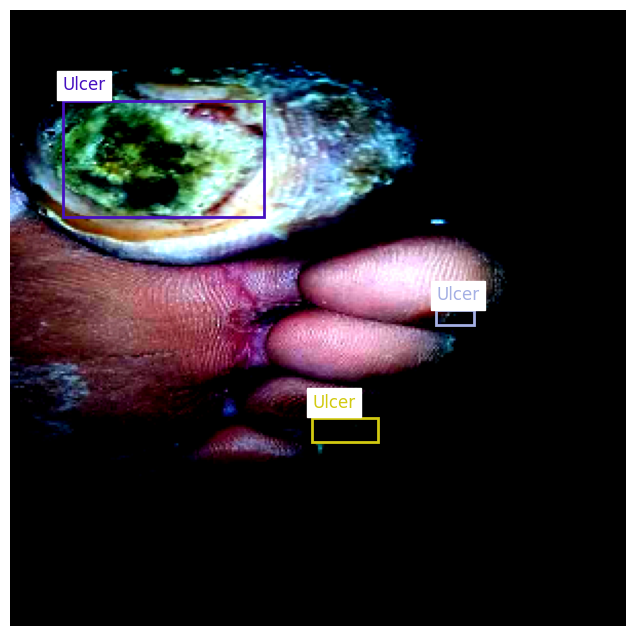

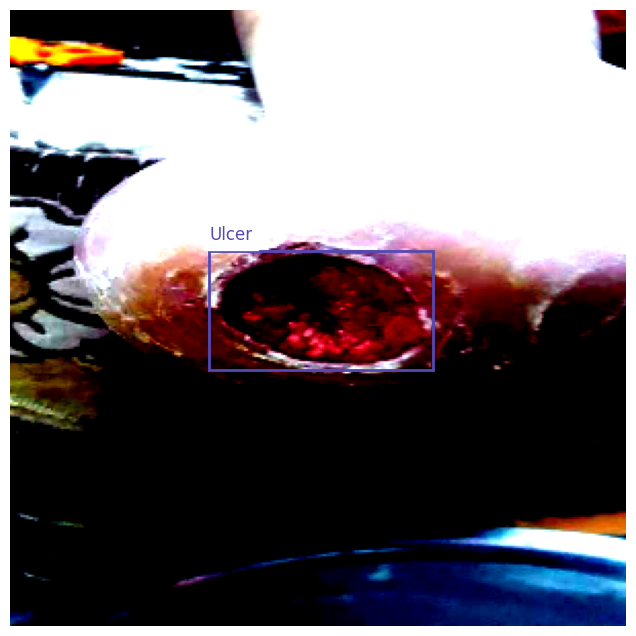

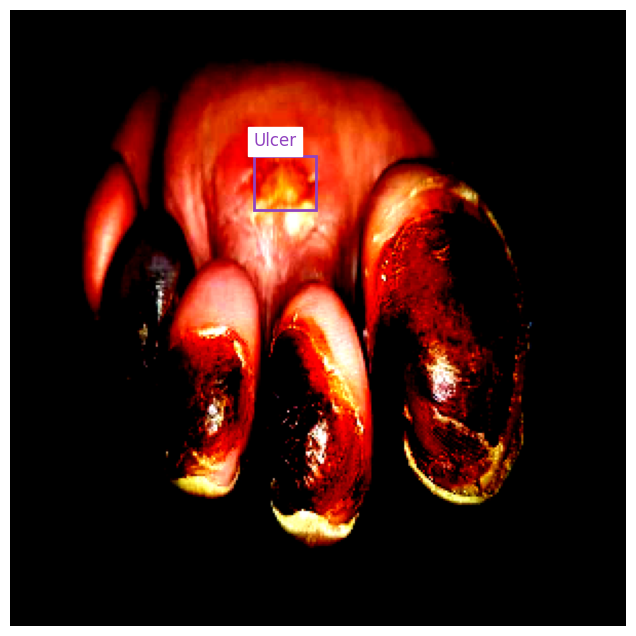

In [8]:
label_map = {
    1: 'Ulcer'
    # Add more if there are other classes
}

for i in range(3):  # show 3 samples
    image, target = train_dataset[i]
    visualize_sample(image, target, label_map)


## Model Development

### Hyperparameter Optimization

In [9]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 26.4 MB/s eta 0:00:00


#### Remove images with no ulcers

In [10]:
# utils/dataset_utils.py
def filter_dataset(dataset):
    filtered = []
    for i in range(len(dataset)):
        _, target = dataset[i]
        if target["boxes"].shape[0] > 0:
            filtered.append(i)
    return torch.utils.data.Subset(dataset, filtered)


#### Using SSD with VGG16 as a backbone

In [11]:
# models/ssd_ulcer.py
import torchvision
from torchvision.models.detection.ssd import SSDClassificationHead

def get_ssd_model(num_classes):
    # Load pretrained SSD model
    model = torchvision.models.detection.ssd300_vgg16(pretrained=True)

    # SSD300 uses these in_channels for its 6 feature maps
    in_channels = [512, 1024, 512, 256, 256, 256]

    # Number of anchors per feature map location (from original SSD paper/config)
    num_anchors = [4, 6, 6, 6, 4, 4]

    # Create new classification head
    model.head.classification_head = SSDClassificationHead(in_channels, num_anchors, num_classes)

    return model


#### Running the optimization

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def objective(trial):
    # Sample hyperparameters
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-2, log=True)

    # Model
    model = get_ssd_model(num_classes=2)
    model.to(device)

    optimizer = torch.optim.SGD(
        [p for p in model.parameters() if p.requires_grad],
        lr=lr,
        momentum=0.9,
        weight_decay=weight_decay
    )
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    # Filter out empty targets|
    train_dataset = UlcerDataset(
        image_dir=train_img_dir,
        annotation_file=train_ann_file,
        transforms=get_train_transforms()
    )

    valid_dataset = UlcerDataset(
        image_dir=valid_img_dir,
        annotation_file=valid_ann_file,
        transforms=get_valid_transforms()
    )

    train_dataset = filter_dataset(train_dataset)
    val_dataset = filter_dataset(valid_dataset)

    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
    val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

    # Train for just a few epochs
    num_epochs = 3
    for epoch in range(num_epochs):
        model.train()
        for images, targets in train_loader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            loss = sum(loss for loss in loss_dict.values())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        scheduler.step()

    # Simple validation loss — you can switch to mAP instead
    # Skip model.eval() — or if you do call it, flip back to train() temporarily
    val_loss = []

    with torch.no_grad():
        for images, targets in val_loader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # ⚠️ SSD only returns loss in train mode
            model.train()
            loss_dict = model(images, targets)
            loss = sum(loss for loss in loss_dict.values())
            val_loss.append(loss.item())

    avg_val_loss = np.mean(val_loss)
    return avg_val_loss



In [13]:
import optuna

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)

print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
print(f"  Params: {trial.params}")


[I 2025-04-09 09:48:09,405] A new study created in memory with name: no-name-6402931d-be87-4ff0-9673-e9033bd586bf
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SSD300_VGG16_Weights.COCO_V1`. You can also use `weights=SSD300_VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/ssd300_vgg16_coco-b556d3b4.pth" to /root/.cache/torch/hub/checkpoints/ssd300_vgg16_coco-b556d3b4.pth
100%|██████████| 136M/136M [00:00<00:00, 200MB/s]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


[W 2025-04-09 09:48:23,173] Trial 0 failed with parameters: {'lr': 0.001029103219926791, 'weight_decay': 0.0005551726081079281} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "<ipython-input-12-22ad8cf2bba1>", line 33, in objective
    train_dataset = filter_dataset(train_dataset)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-10-de90c7eba9a1>", line 5, in filter_dataset
    _, target = dataset[i]
                ~~~~~~~^^^
  File "<ipython-input-4-eb0679daa7fe>", line 22, in __getitem__
    image = cv2.imread(image_path)
            ^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt
[W 2025-04-09 09:48:23,174] Trial 0 failed with value None.


KeyboardInterrupt: 

### Training

#### Helpers

In [14]:
import torch
import torchvision

def get_optimizer(model, lr=1e-3, weight_decay=1e-4):
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=lr, momentum=0.9, weight_decay=weight_decay)
    return optimizer

def get_lr_scheduler(optimizer):
    return torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


#### Using dataloaders

In [16]:
from torch.utils.data import DataLoader
train_dataset = filter_dataset(train_dataset)
valid_dataset = filter_dataset(valid_dataset)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

#### Training the model

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Best trial:
#   Value: 3.5569063425064087
#   Params: {'lr': 0.0005163810911107111, 'weight_decay': 0.000716981970219033}

# === Hyperparameters (from Optuna) ===
lr = 0.0005163810911107111
weight_decay = 0.000716981970219033
num_epochs = 25
batch_size = 8

# === Dataloaders ===
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(valid_dataset, batch_size=batch_size//2, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

# === Model ===
model = get_ssd_model(num_classes=2)
model.to(device)

# === Optimizer & Scheduler ===
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=lr, momentum=0.9, weight_decay=weight_decay)
lr_scheduler = get_lr_scheduler(optimizer)

# === Training ===
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    for images, targets in train_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    lr_scheduler.step()

    print(f"[Epoch {epoch+1}/{num_epochs}] Loss: {epoch_loss:.4f}")

torch.save(model.state_dict(), "/content/drive/MyDrive/ssd_ulcer_final_weights.pth")

[Epoch 1/25] Loss: 224.3468
[Epoch 2/25] Loss: 150.4041
[Epoch 3/25] Loss: 132.9328
[Epoch 4/25] Loss: 118.3433
[Epoch 5/25] Loss: 107.1544
[Epoch 6/25] Loss: 97.2055
[Epoch 7/25] Loss: 95.3791
[Epoch 8/25] Loss: 93.9963
[Epoch 9/25] Loss: 92.6770
[Epoch 10/25] Loss: 91.3024
[Epoch 11/25] Loss: 89.8994
[Epoch 12/25] Loss: 89.7663
[Epoch 13/25] Loss: 88.4636
[Epoch 14/25] Loss: 90.5859
[Epoch 15/25] Loss: 88.2768
[Epoch 16/25] Loss: 89.0330
[Epoch 17/25] Loss: 88.9568
[Epoch 18/25] Loss: 88.8954
[Epoch 19/25] Loss: 88.4168
[Epoch 20/25] Loss: 90.0548
[Epoch 21/25] Loss: 89.8020
[Epoch 22/25] Loss: 88.5929
[Epoch 23/25] Loss: 88.3843
[Epoch 24/25] Loss: 88.7607
[Epoch 25/25] Loss: 89.7910


### Evaluation

In [17]:
pip install pycocotools

##### Reading the testset using DataLoader

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_path = '/content/drive/MyDrive/ssd_ulcer_final_weights.pth'

# === Load Model ===
model = get_ssd_model(num_classes=2)  # ulcer + background
model.load_state_dict(torch.load(model_path))
model.to(device)
model.eval()

# === Load Test Dataset ===
test_dataset = filter_dataset(test_dataset)

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SSD300_VGG16_Weights.COCO_V1`. You can also use `weights=SSD300_VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


#### Calculate Precision, Recall, F1, mAP

In [24]:
def calculate_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA) * max(0, yB - yA)
    if interArea == 0:
        return 0.0

    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

In [25]:
def evaluate_f1(model, dataloader, iou_threshold=0.5, score_threshold=0.5):
    model.eval()
    tp, fp, fn = 0, 0, 0

    with torch.no_grad():
        for images, targets in tqdm(dataloader):
            image = images[0].to(device)
            gt_boxes = targets[0]['boxes'].cpu().tolist()

            preds = model([image])[0]
            pred_boxes = preds['boxes'].cpu().tolist()
            scores = preds['scores'].cpu().tolist()

            # Filter low-confidence predictions
            pred_boxes = [box for i, box in enumerate(pred_boxes) if scores[i] >= score_threshold]

            matched_gt = set()
            for pb in pred_boxes:
                pb_box = [pb[0], pb[1], pb[2], pb[3]]
                found_match = False
                for i, gt in enumerate(gt_boxes):
                    if i in matched_gt:
                        continue
                    iou = calculate_iou(pb_box, gt)
                    if iou >= iou_threshold:
                        tp += 1
                        matched_gt.add(i)
                        found_match = True
                        break
                if not found_match:
                    fp += 1

            fn += len(gt_boxes) - len(matched_gt)

    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-6)

    return precision, recall, f1


In [27]:
precision, recall, f1 = evaluate_f1(model, test_loader)
print("")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

100%|██████████| 78/78 [00:02<00:00, 36.89it/s]


Precision: 0.8814
Recall:    0.3210
F1 Score:  0.4706


### Visualizations

In [28]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch

#### Function to bring images to their original state

In [37]:
# utils/visualize.py or wherever you put your visual code
def denormalize_image(tensor, mean, std):
    """
    Convert a normalized image tensor back to [0, 1] for visualization
    tensor: (3, H, W)
    """
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor.clamp(0, 1)


In [38]:
def visualize_prediction(image, target, prediction, label_map=None, score_threshold=0.5):
    """
    - image: Tensor (3, H, W)
    - target: dict with 'boxes', 'labels'
    - prediction: dict with 'boxes', 'labels', 'scores'
    """
    IMAGENET_MEAN = [0.485, 0.456, 0.406]
    IMAGENET_STD = [0.229, 0.224, 0.225]

    denorm = denormalize_image(image.clone(), IMAGENET_MEAN, IMAGENET_STD)
    image_np = denorm.permute(1, 2, 0).cpu().numpy()


    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.imshow(image_np)

    # Plot ground truth (green)
    for box in target['boxes']:
        x1, y1, x2, y2 = box.tolist()
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                 linewidth=2, edgecolor='green', facecolor='none')
        ax.add_patch(rect)
        ax.text(x1, y1 - 5, 'GT', color='green', fontsize=12, weight='bold')

    # Plot predictions (red)
    for box, score, label in zip(prediction['boxes'], prediction['scores'], prediction['labels']):
        if score < score_threshold:
            continue
        x1, y1, x2, y2 = box.tolist()
        label_text = label_map[label.item()] if label_map else f"Class {label.item()}"
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                 linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        ax.text(x1, y1 + 15, f"{label_text}: {score:.2f}", color='red', fontsize=10, backgroundcolor="white")

    plt.axis('off')
    plt.tight_layout()
    plt.show()


In [39]:
# visualize_multiple.py
def visualize_multiple_predictions(model, dataloader, label_map=None, score_threshold=0.5, num_images=10):
    model.eval()
    shown = 0

    with torch.no_grad():
        for images, targets in dataloader:
            image = images[0].to(device)
            target = targets[0]
            prediction = model([image])[0]

            visualize_prediction(image.cpu(), target, prediction, label_map, score_threshold)

            shown += 1
            if shown >= num_images:
                break

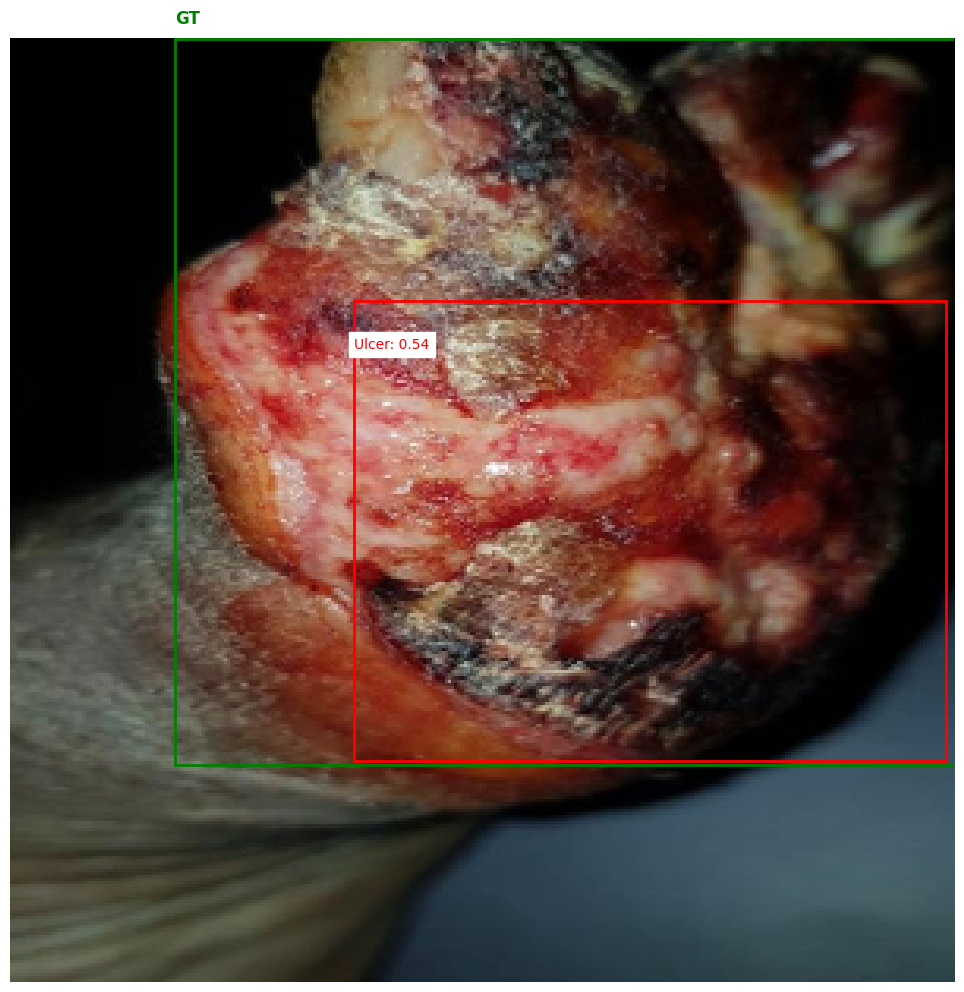

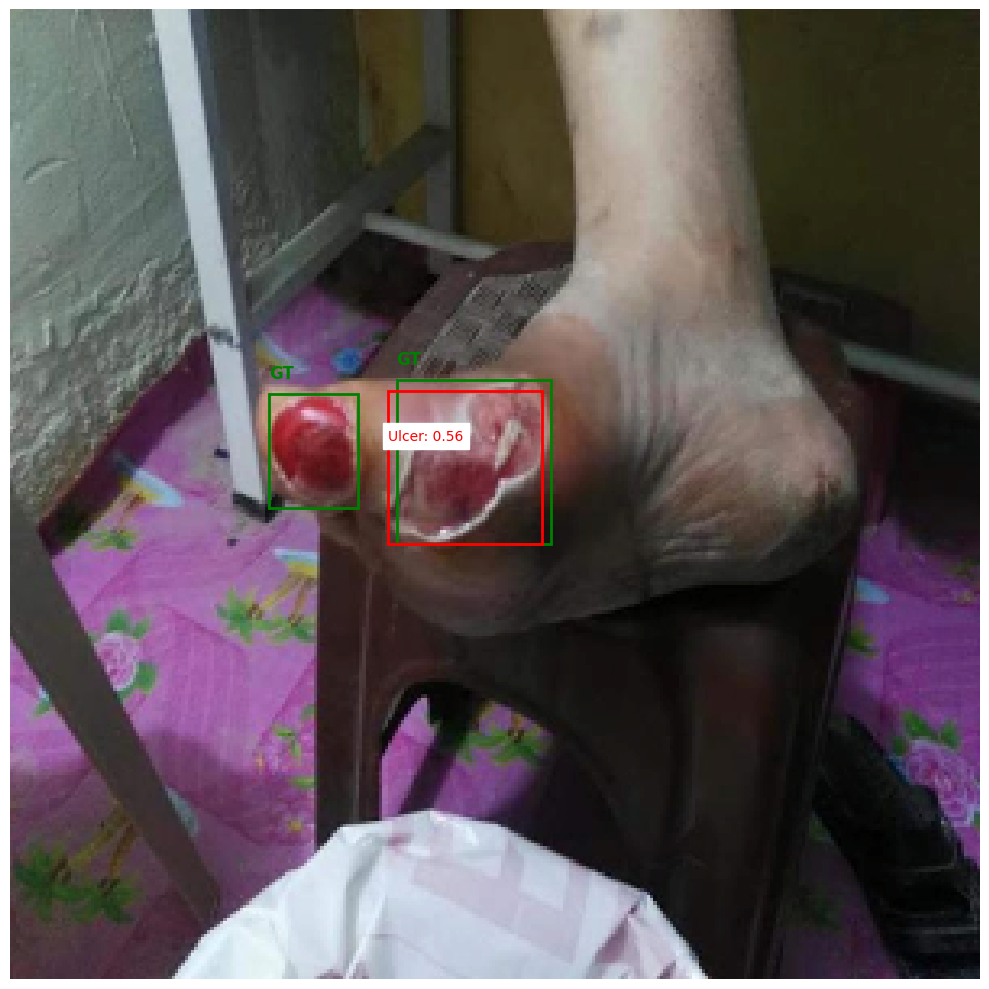

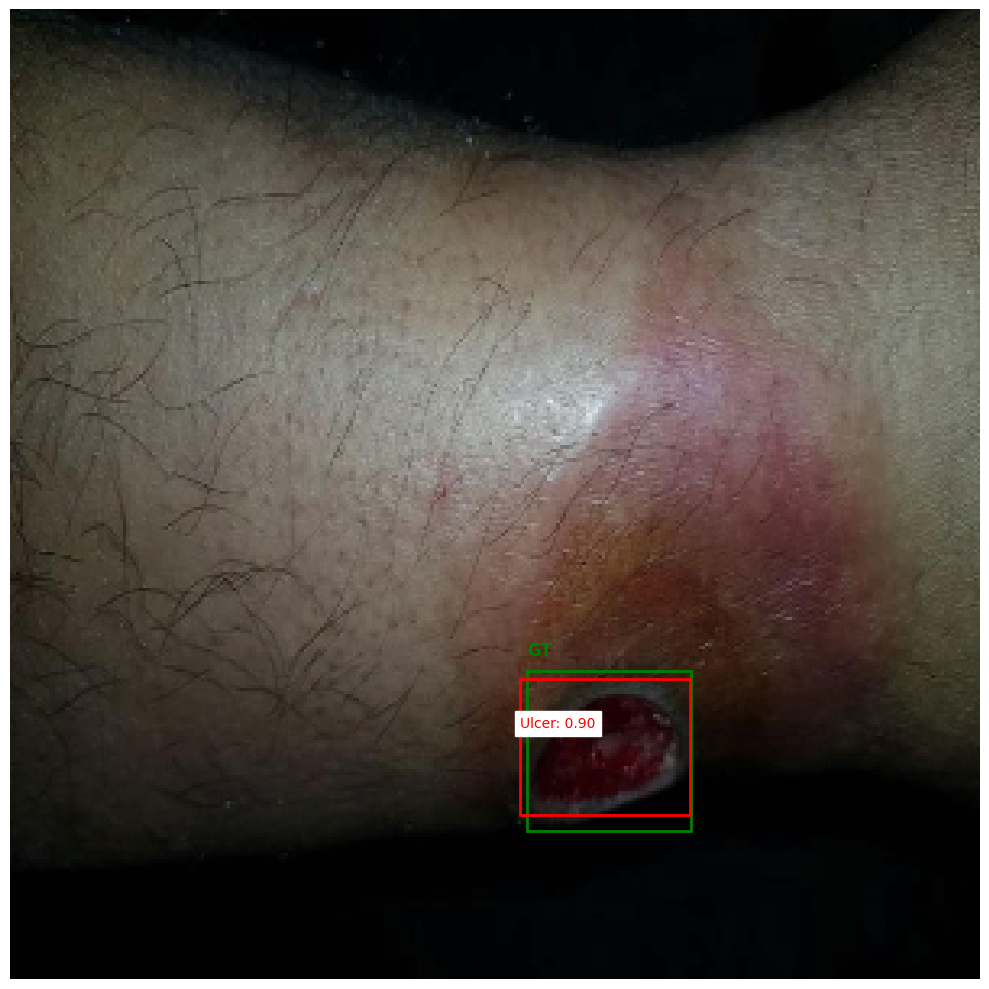

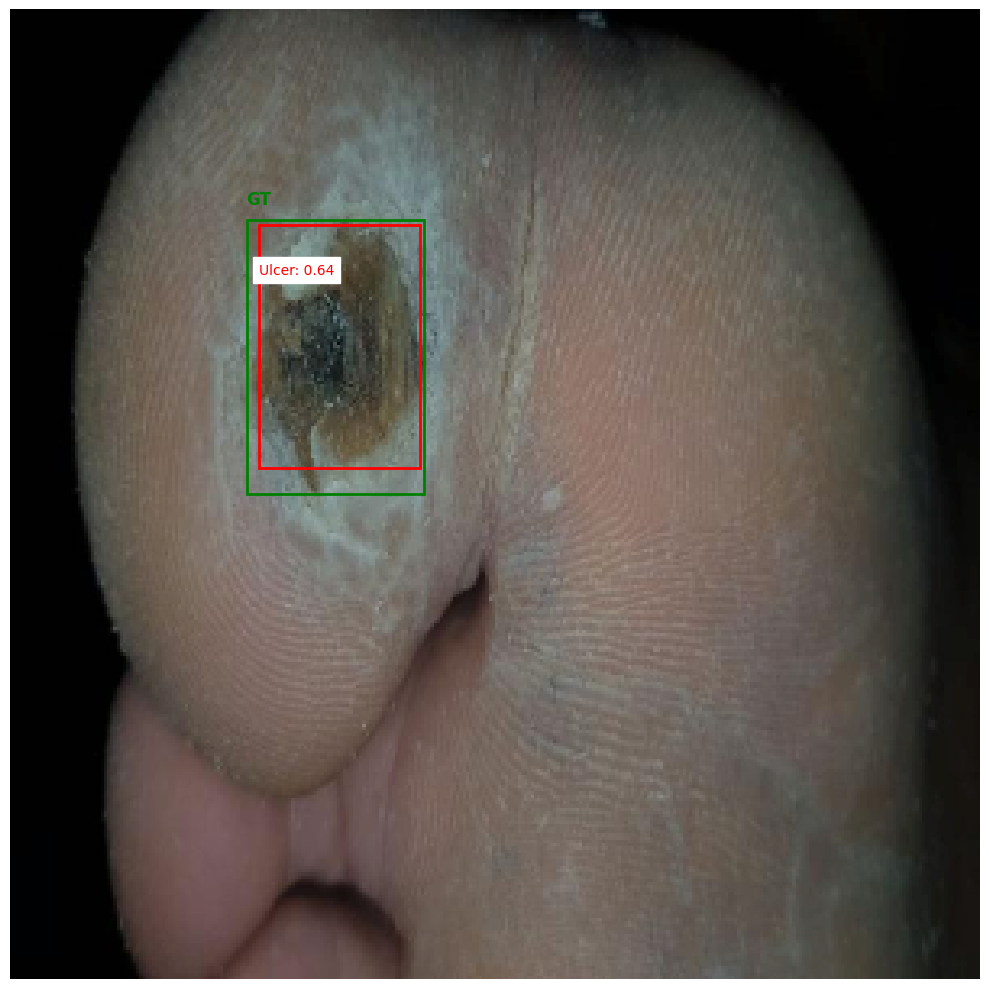

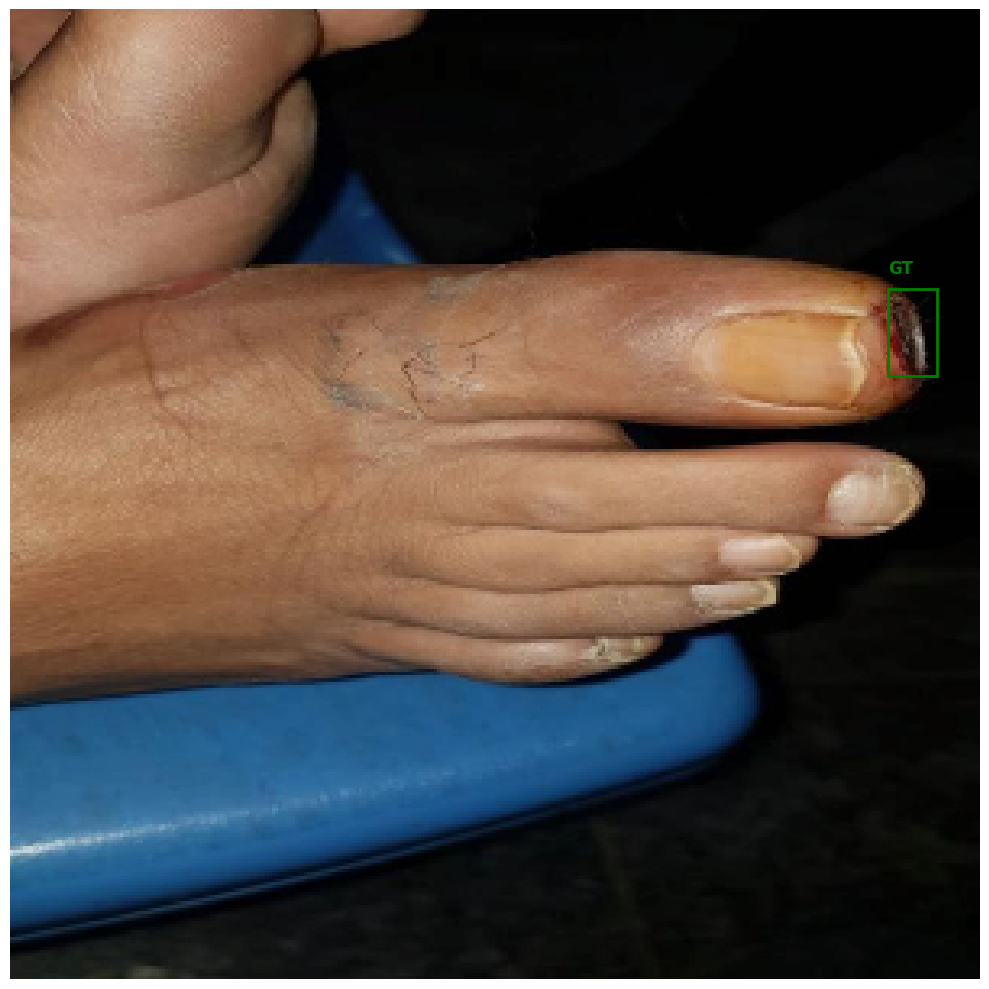

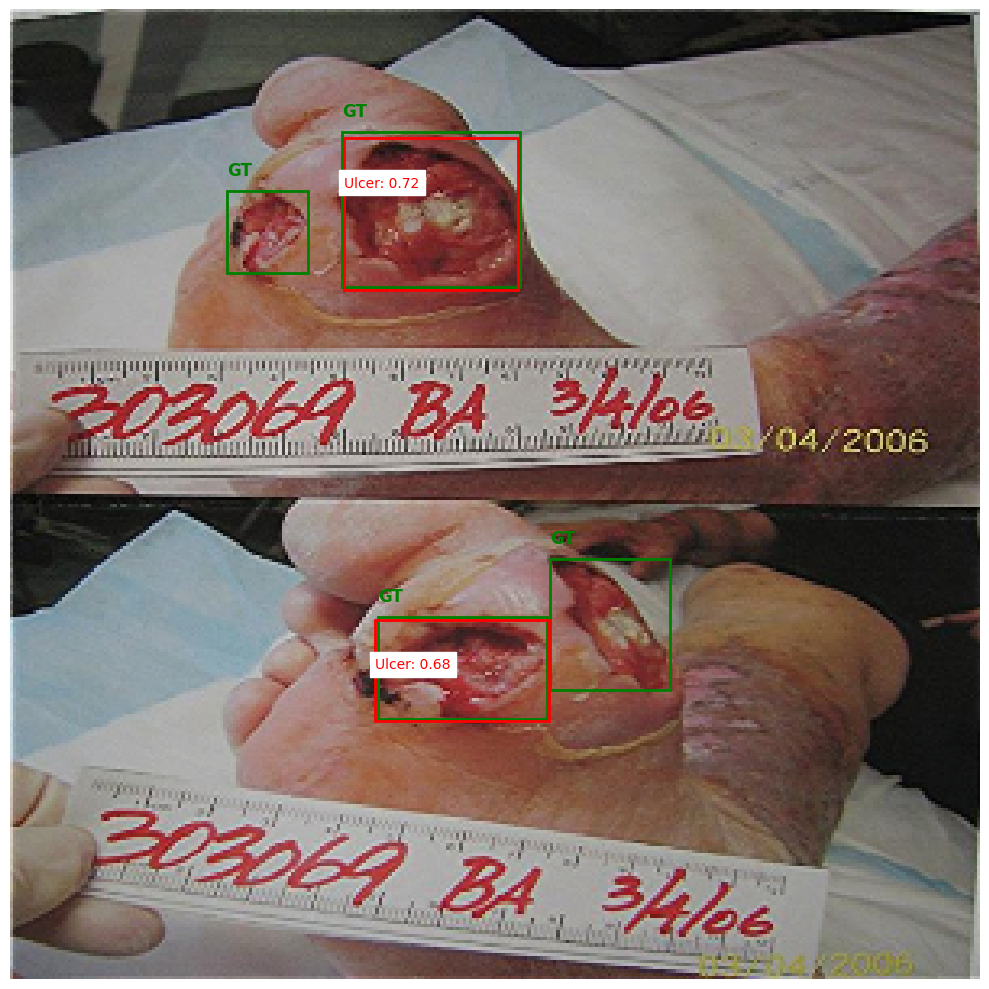

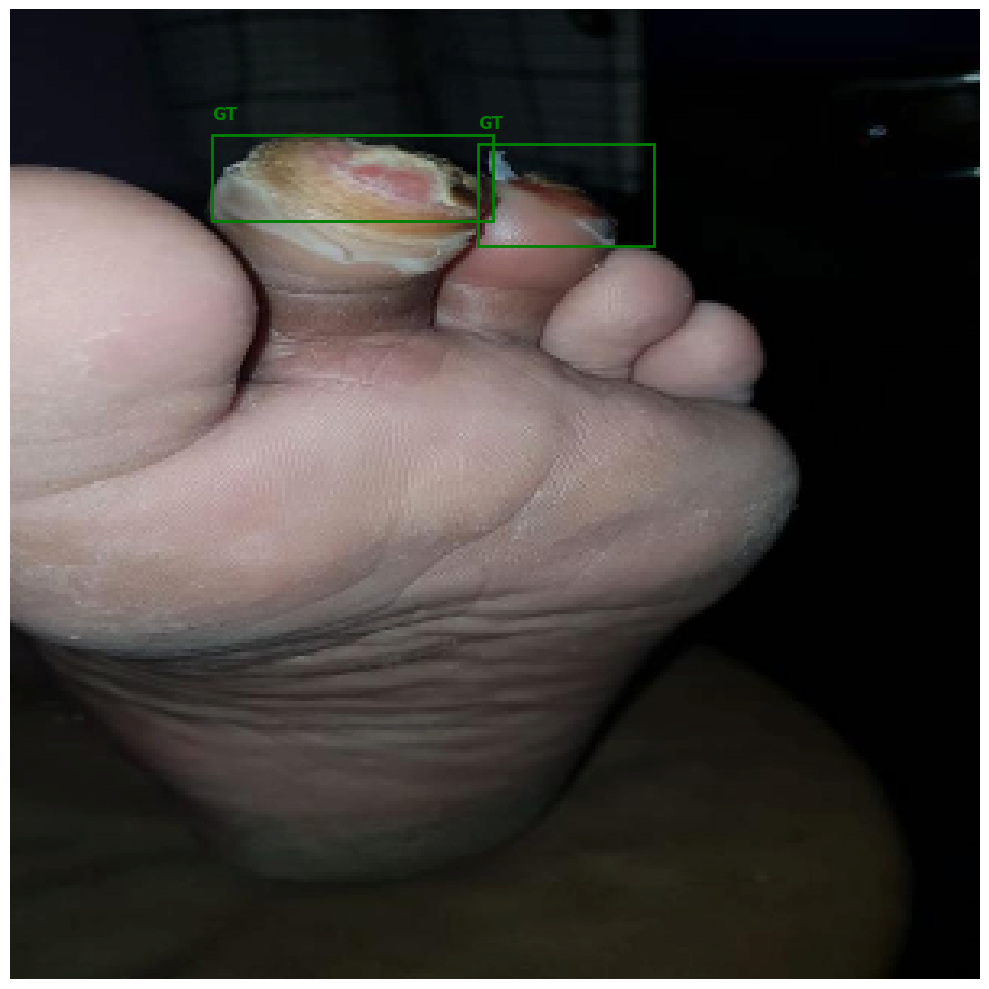

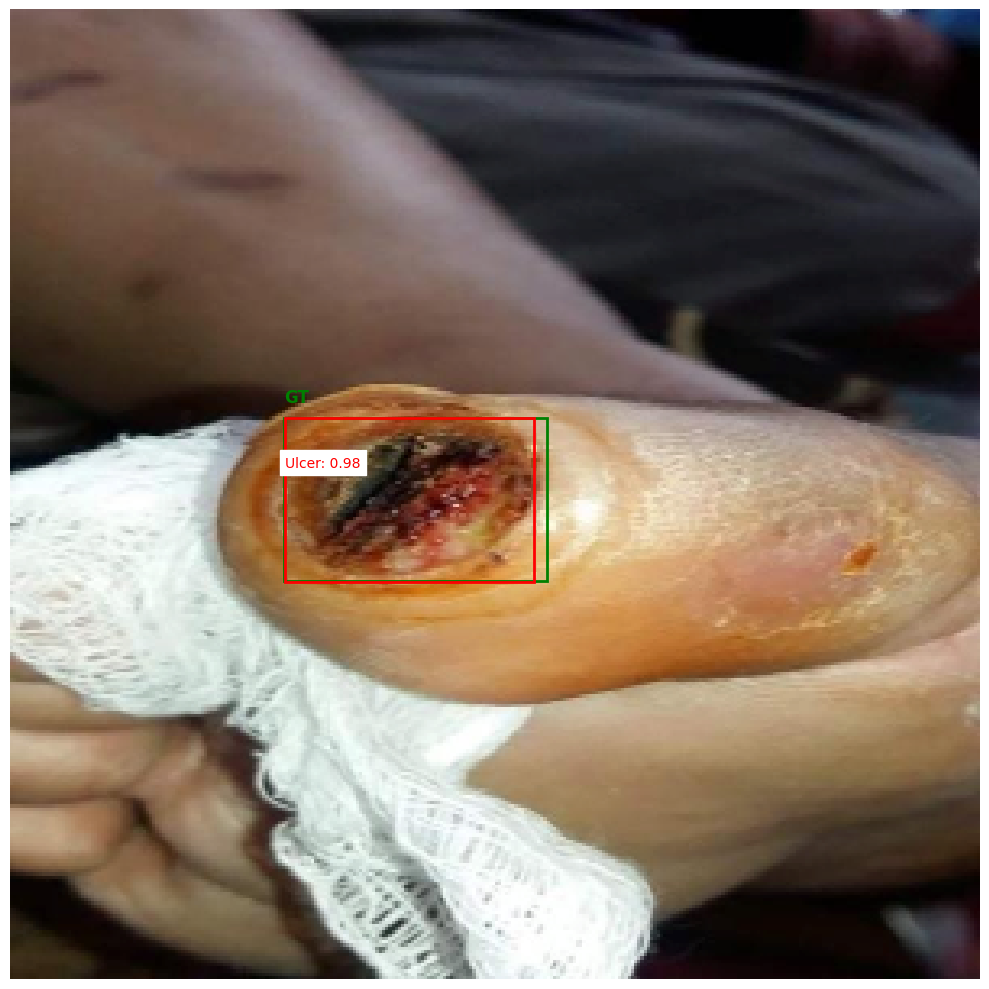

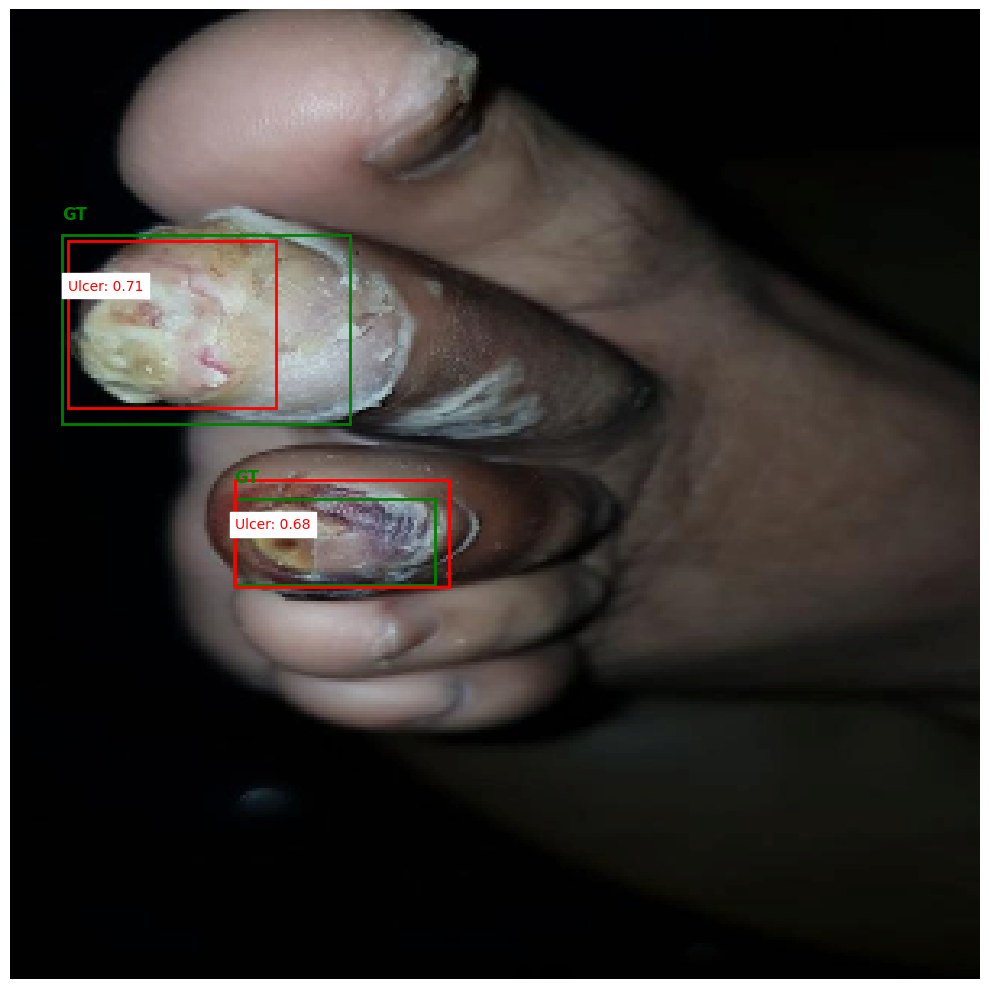

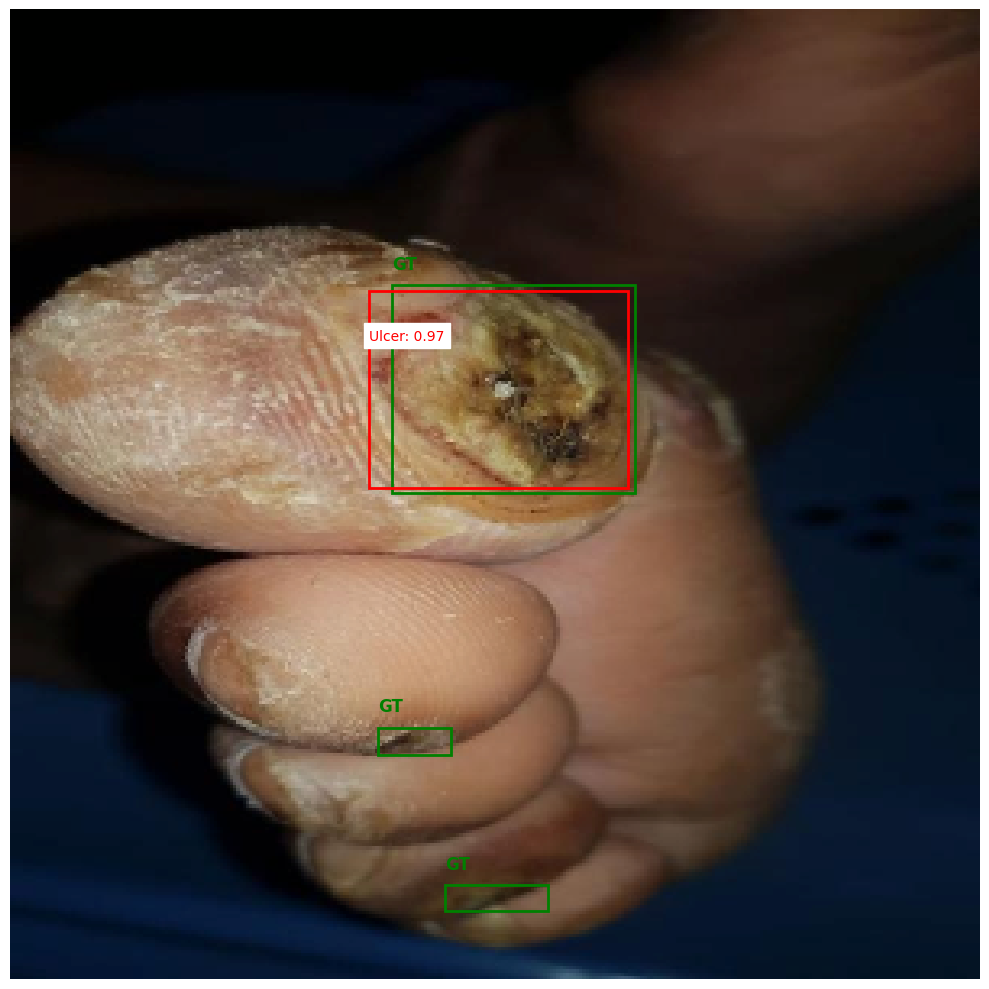

In [40]:
visualize_multiple_predictions(
    model=model,
    dataloader=test_loader,
    label_map={1: "Ulcer"},
    score_threshold=0.5,
    num_images=10
)